<a href="https://colab.research.google.com/github/sumithskk/Car_Price_Prediction-MachineHack-Mathcothon-/blob/main/Car_Price_Prediction_MachineHack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MATHCOTHON - Car Price Prediction

# 1. Data Preparation

In [1]:
# Import all libraries required
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use('default')

from warnings import filterwarnings
filterwarnings('ignore')
#scipy libraries
from scipy import stats
from scipy.stats import norm, skew#for some statistics
from scipy.special import boxcox,inv_boxcox

#sklearn libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load train and test dataset
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bootcamp/Machine-Hack/train.csv")
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bootcamp/Machine-Hack/test.csv')
train.head(2)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


In [4]:
test.head(2)

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
0,44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,02-Mar,Left wheel,Grey,10,NaN
1,45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,04-May,Left wheel,Grey,10,NaN


In [5]:
#print dataset shape
print("Train datast shape ",train.shape)
print("Test dataset shape",test.shape)

Train datast shape  (19237, 18)
Test dataset shape (8245, 18)


# 2. Exploratory Data Analysis 

In [6]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))


The train data size after dropping Id feature is : (19237, 17) 
The test data size after dropping Id feature is : (8245, 17) 


### Outliers

In [7]:
# Start with price
# Check for the percentile range, mean and std of price values
train['Price'].describe(percentiles=[0,0.25,0.5,0.75,0.8,0.9,1])

count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
0%       1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
80%      2.551200e+04
90%      3.860900e+04
100%     2.630750e+07
max      2.630750e+07
Name: Price, dtype: float64

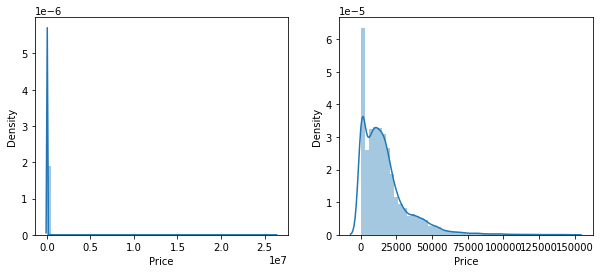

In [8]:
# Plot price distribution
fig, axs = plt.subplots(1,2,figsize=(10,4))
sns.distplot(train['Price'],ax=axs[0])

#Remove price values  greater than 1e7
train[(train['Price']>15e4)] = train['Price'].mode()[0]

sns.distplot(train['Price'],ax=axs[1])


 mu = 16873.77 and sigma = 16895.90



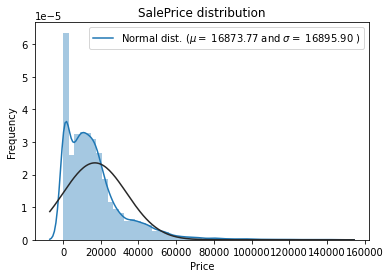

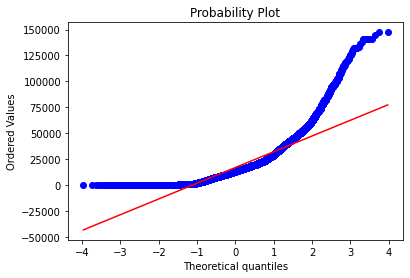

In [9]:
#Price is the variable we need to predict. So let's do some analysis on this variable first.

sns.distplot(train['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()


The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

In [10]:
train.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [11]:
# We have to do some feature extractions 
# Separate out the categorical features and numerical features 
cat_features = [feature for feature in train.columns if train[feature].dtype=="O"]
num_features = [feature for feature in train.columns if train[feature].dtype!="O"]

In [12]:
num_features ,cat_features

(['Price', 'Prod. year', 'Cylinders', 'Airbags'],
 ['Levy',
  'Manufacturer',
  'Model',
  'Category',
  'Leather interior',
  'Fuel type',
  'Engine volume',
  'Mileage',
  'Gear box type',
  'Drive wheels',
  'Doors',
  'Wheel',
  'Color'])

In [13]:
#Convert Numerical to categorical if any is there
#Cylinders
#train['Cylinders'].value_counts()
train['Cylinders'] = train['Cylinders'].apply(str)
test['Cylinders'] = test['Cylinders'].apply(str)

In [14]:
#Airbags
#train['Airbags'].value_counts()
train['Airbags'] = train['Airbags'].apply(str)
test['Airbags'] = test['Airbags'].apply(str)

In [15]:
#Later think about Prod year and Engine volume

In [16]:
for feature in cat_features:
    print('Unique features in {} : {}'.format(feature,len(train[feature].unique())))

Unique features in Levy : 558
Unique features in Manufacturer : 64
Unique features in Model : 1578
Unique features in Category : 12
Unique features in Leather interior : 3
Unique features in Fuel type : 8
Unique features in Engine volume : 105
Unique features in Mileage : 7680
Unique features in Gear box type : 5
Unique features in Drive wheels : 4
Unique features in Doors : 4
Unique features in Wheel : 3
Unique features in Color : 17


In [17]:
# Convert object to Numerical
# Levy,Mileage,Engine volume

In [18]:
# Engine volume - Train 
train['Turbulance']=train['Engine volume'].replace(['2.0 Turbo', '2.2 Turbo','3.0 Turbo','1.4 Turbo','1.5 Turbo', '1.6 Turbo','2.3 Turbo','2.8 Turbo','1.8 Turbo', '2.4 Turbo', '3.5 Turbo', '3.2 Turbo','1.3 Turbo','2.5 Turbo','1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.2 Turbo','4.8 Turbo', '4.6 Turbo','1.2 Turbo','1.7 Turbo', '6.3 Turbo', '2.7 Turbo','2.9 Turbo', '4.0 Turbo','3.6 Turbo','3.7 Turbo','5.5 Turbo','2.1 Turbo','0.7 Turbo', '0.6 Turbo','1.0 Turbo', '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo','5.7 Turbo','0.4 Turbo', '5.4 Turbo', '0.3 Turbo','1.1 Turbo'],'Turbo')

train['Turbulance']=train['Turbulance'].replace(['3.5','3','1.3','2.5','2','1.8','2.4','4','1.6','3.3','4.7','1.5','4.4','3.6','2.3','2.2','1.4','5.5','3.2','3.8','4.6','1.2','5', '1.7', '2.9', '0.5','1.9','2.7','4.8','5.3','0.4','2.8','1.1','2.1','0.7','5.4','3.7','1','2.6','5.7','3.4','4.3','4.2','5.9','6.8','4.5','0.6','7.3','0.1','6.3','6.4','5.2','5.8','0.8', '6.7', '6.2', '0', '20', '0.3', '0.2','5.6', '6', '3.9', '0.9'],'Non-Turbo')


In [19]:
#Engine volume - test
test['Turbulance']=test['Engine volume'].replace(['2.0 Turbo', '2.2 Turbo','3.0 Turbo','1.4 Turbo','1.5 Turbo', '1.6 Turbo','2.3 Turbo','2.8 Turbo','1.8 Turbo', '2.4 Turbo', '3.5 Turbo', '3.2 Turbo','1.3 Turbo','2.5 Turbo','1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.2 Turbo','4.8 Turbo', '4.6 Turbo','1.2 Turbo','1.7 Turbo', '6.3 Turbo', '2.7 Turbo','2.9 Turbo', '4.0 Turbo','3.6 Turbo','3.7 Turbo','5.5 Turbo','2.1 Turbo','0.7 Turbo', '0.6 Turbo','1.0 Turbo', '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo','5.7 Turbo','0.4 Turbo', '5.4 Turbo', '0.3 Turbo','1.1 Turbo','6.0 Turbo','2.6 Turbo'],'Turbo')

test['Turbulance']=test['Turbulance'].replace(['3.5','3','1.3','2.5','2','1.8','2.4','4','1.6','3.3','4.7','1.5','4.4','3.6','2.3','2.2','1.4','5.5','3.2','3.8','4.6','1.2','5', '1.7', '2.9', '0.5','1.9','2.7','4.8','5.3','0.4','2.8','1.1','2.1','0.7','5.4','3.7','1','2.6','5.7','3.4','4.3','4.2','5.9','6.8','4.5','0.6','7.3','0.1','6.3','6.4','5.2','5.8','0.8', '6.7', '6.2', '0', '20', '0.3', '0.2','5.6', '6', '3.9', '0.9','6.6', '6.1', '10.8'],'Non-Turbo')

In [20]:
# remove Turbo - Train
train['Engine volume'] = train['Engine volume'].str.replace('Turbo',' ')
# Str to float
train['Engine volume'] = train['Engine volume'].astype(float)

# remove Turbo - Test
test['Engine volume'] = test['Engine volume'].str.replace('Turbo',' ')
# Str to float
test['Engine volume'] = test['Engine volume'].astype(float)

In [21]:
# Mileage - Train
train['Mileage'] = train['Mileage'].str.replace('km',' ')
train['Mileage'] = train["Mileage"].astype(float)

# Mileage  -Test
test['Mileage'] = test['Mileage'].str.replace('km',' ')
test['Mileage'] = test["Mileage"].astype(float)

In [22]:
# Levy - train
train['Levy']= train['Levy'].replace({'-':np.nan})
train["Levy"]= train["Levy"].astype(float)

# Levy - Test
test['Levy']= test['Levy'].replace({'-':np.nan})
test["Levy"]= test["Levy"].astype(float)

In [23]:
# Check for the null values
train.isnull().sum()

Price                  0
Levy                5802
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume         27
Mileage               27
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
Turbulance             0
dtype: int64

In [24]:
# Since there ar outlies we can replace the Nan with mode value
train['Levy'] = train['Levy'].fillna(train['Levy'].mode()[0])
train['Engine volume'] = train['Engine volume'].fillna(train['Engine volume'].mode()[0])
train['Mileage'] = train['Mileage'].fillna(train['Mileage'].mode()[0])

test['Levy'] = test['Levy'].fillna(test['Levy'].mode()[0])

Label Encoding some categorical variables that may contain information in their ordering set

In [25]:
from sklearn.preprocessing import LabelEncoder
cols = ('Cylinders','Gear box type','Drive wheels','Doors','Airbags')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))
    test[c]  = lbl.fit_transform(list(test[c].values))
# shape        
print('Shape all_data: {}'.format(train.shape))
print('Shape all_data: {}'.format(test.shape))

Shape all_data: (19237, 18)
Shape all_data: (8245, 18)


In [26]:
train.select_dtypes(include=np.number).head()

,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Airbags
0,13328,1399.0,2010,3.5,186005.0,10,1,1,1,4
1,16621,1018.0,2011,3.0,192000.0,10,3,1,1,16
2,8467,765.0,2006,1.3,200000.0,8,4,2,1,10
3,3607,862.0,2011,2.5,168966.0,8,1,1,1,0
4,11726,446.0,2014,1.3,91901.0,8,1,2,1,12


In [27]:
# Check for the outliers in the following columns
#Levy, Prod.year, Engien volume, Mileage

Text(0, 0.5, 'Price')

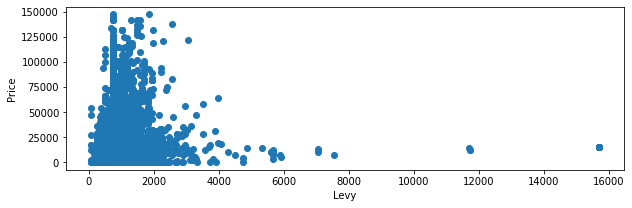

In [28]:
# Levy
plt.figure(figsize=(10,3))
plt.scatter(train['Levy'],train['Price'])
plt.xlabel('Levy')
plt.ylabel('Price')


449.5 1197.5


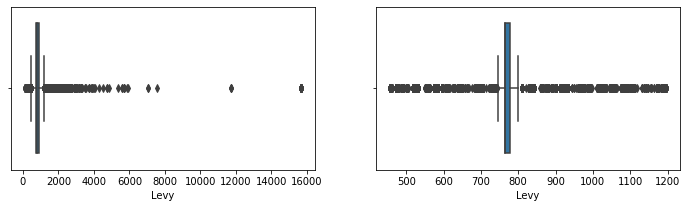

In [29]:
fig,axs = plt.subplots(1,2,figsize=(12,3))
sns.boxplot(train['Levy'],ax=axs[0])
Q1 = train['Levy'].quantile(0.25)
Q3 = train['Levy'].quantile(0.75)
IQR = Q3-Q1
print(Q1-1.5*IQR,Q3+1.5*IQR)
# We can replace the values outside the iqr range
filter = (train['Levy']<Q1-1.5*IQR) | (train['Levy']>Q3+1.5*IQR)
train['Levy'][filter] = train['Levy'].mode()[0]

sns.boxplot(train['Levy'],ax=axs[1])

Text(0, 0.5, 'Price')

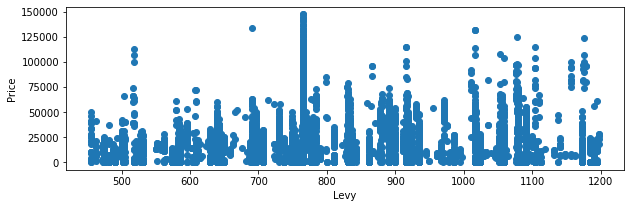

In [30]:
# Levy
plt.figure(figsize=(10,3))
plt.scatter(train['Levy'],train['Price'])
plt.xlabel('Levy')
plt.ylabel('Price')

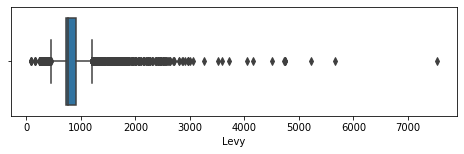

In [31]:
# Test data
plt.figure(figsize=(8,2))
sns.boxplot(test['Levy'])

2000.0 2024.0


(array([1985., 1990., 1995., 2000., 2005., 2010., 2015., 2020., 2025.]),
 <a list of 9 Text major ticklabel objects>)

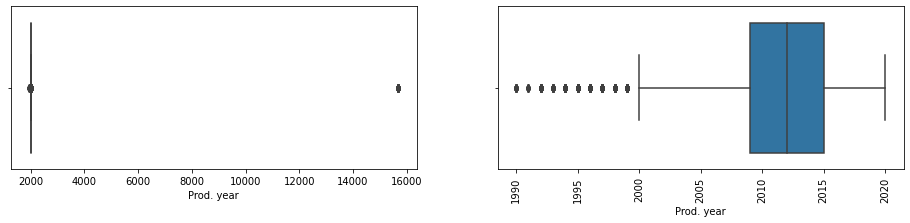

In [32]:
# Prod. year - train
fig,axs = plt.subplots(1,2,figsize=(16,3))
sns.boxplot(train['Prod. year'],ax=axs[0])
Q1 = train['Prod. year'].quantile(0.25)
Q3 = train['Prod. year'].quantile(0.75)
IQR = Q3-Q1
print(Q1-1.5*IQR,Q3+1.5*IQR)

 #We can replace the values outside the iqr range
filter = (train['Prod. year']< 1990) | (train['Prod. year']>Q3+1.5*IQR)
train['Prod. year'][filter] = train['Prod. year'].mode()[0]

sns.boxplot(train['Prod. year'],ax=axs[1])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

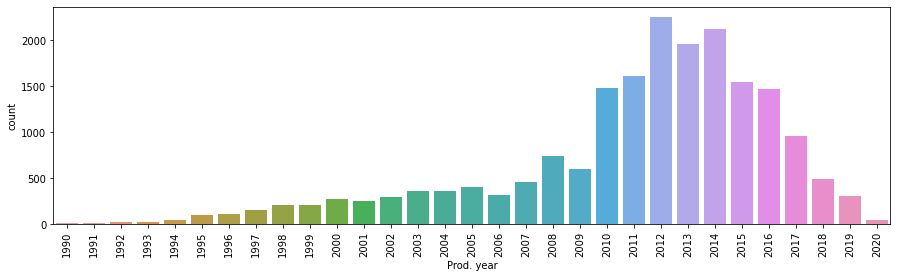

In [33]:
plt.figure(figsize=(15,4))
sns.countplot(train['Prod. year'])
plt.xticks(rotation=90)

In [34]:
#For test data
# We can replace the years less than 1990 by mode value
test[test['Prod. year']<1990] = test['Prod. year'].mode()[0]

0.7500000000000002 3.55


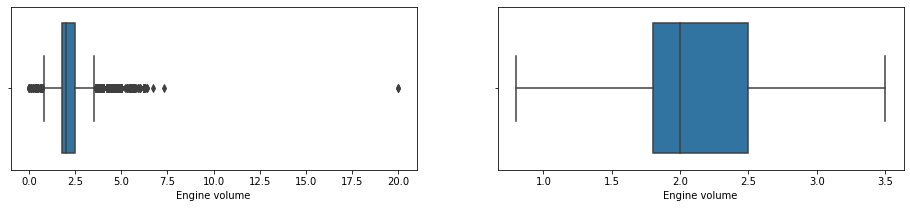

In [35]:
fig,axs = plt.subplots(1,2,figsize=(16,3))
sns.boxplot(train['Engine volume'],ax=axs[0])
Q1 = train['Engine volume'].quantile(0.25)
Q3 = train['Engine volume'].quantile(0.75)
IQR = Q3-Q1
print(Q1-1.5*IQR,Q3+1.5*IQR)

filter = (train['Engine volume']< Q1-1.5*IQR) | (train['Engine volume']>Q3+1.5*IQR)
train['Engine volume'][filter] = train['Engine volume'].mode()[0]
sns.boxplot(train['Engine volume'],ax=axs[1])

-108332.0 367220.0


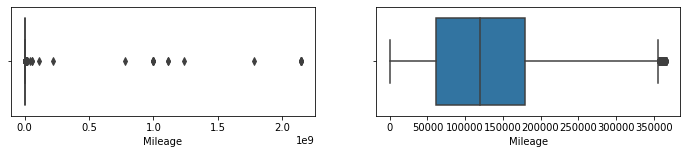

In [36]:
# Mileage - train
fig,axs = plt.subplots(1,2,figsize=(12,2))
sns.boxplot(train['Mileage'],ax=axs[0])
Q1 = train['Mileage'].quantile(0.25)
Q3 = train['Mileage'].quantile(0.75)
IQR = Q3-Q1
print(Q1-1.5*IQR,Q3+1.5*IQR)

filter = (train['Mileage']<Q1-1.5*IQR) | (train['Mileage']>Q3+1.5*IQR)
train['Mileage'][filter] = train['Mileage'].mode()[0]
sns.boxplot(train['Mileage'],ax=axs[1])

-110500.0 373500.0


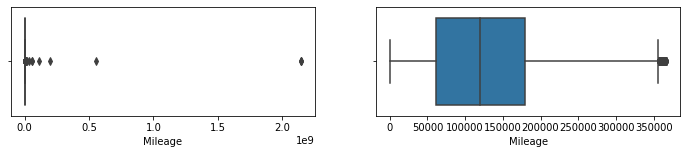

In [37]:
# Mileage - test
fig,axs = plt.subplots(1,2,figsize=(12,2))
sns.boxplot(test['Mileage'],ax=axs[0])
Q1 = test['Mileage'].quantile(0.25)
Q3 = test['Mileage'].quantile(0.75)
IQR = Q3-Q1
print(Q1-1.5*IQR,Q3+1.5*IQR)

filter = (train['Mileage']<Q1-1.5*IQR) | (train['Mileage']>Q3+1.5*IQR)
train['Mileage'][filter] = train['Mileage'].mode()[0]
sns.boxplot(train['Mileage'],ax=axs[1])

In [38]:
#For the moment drop 'Manufacturer' and 'Model'
train.drop(['Manufacturer','Model'],axis=1,inplace=True)

test.drop(['Manufacturer','Model'],axis=1,inplace=True)

In [39]:
# Dummy categorical features
train = pd.get_dummies(train,drop_first=True)

test = pd.get_dummies(test,drop_first=True)

In [40]:
train.shape,test.shape

((19237, 50), (8245, 50))

In [41]:
plt.figure(figsize=(20,20))
corr = train.corr()
#sns.heatmap(corr,square=True)

<Figure size 1440x1440 with 0 Axes>

In [42]:
y = train.Price.values
train.drop(['Price'],axis=1,inplace=True)
test.drop(['Price'],axis=1,inplace=True)

In [43]:
# We can use Minmaxscaler scaler to scale the data
scaler = MinMaxScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train),columns=train.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test),columns=train.columns)


 mu = 9.02 and sigma = 1.58



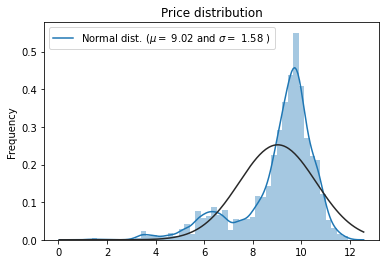

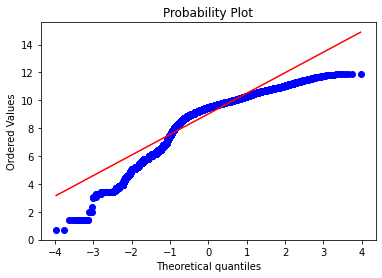

In [44]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#y = boxcox1p(y,0.25)
y = np.log1p(y)

#train_data["Price"] = np.log1p(train_data['Price']+1)
#Check the new distribution 
sns.distplot(y , fit=norm);

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()


# 3. Modelling

In [45]:
# Libraries required for Modelling and Evaluation
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from scipy.special import boxcox1p,inv_boxcox1p

import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import KFold,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [46]:
# Define root_meansquared_log_error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [47]:
#Split the data into training and testing
x_train,x_test,y_train,y_test = train_test_split(train_scaled,y,test_size=0.25,random_state=0)

In [48]:
# Random Forest Model - Fit model
model = RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=1,max_features='sqrt',max_depth=5)
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# 4. Evaluation

In [49]:
# Predict the outputs for test data
y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)
print('Train auc', rmsle(y_pred_train,y_train))
print('Test auc', rmsle(y_pred_test,y_test))

Train auc 0.1615992865943931
Test auc 0.16444644563254046


In [50]:
#Evaluate the model using mean_sqaured_log_error
y_pred_train = np.expm1(model.predict(x_train))
y_pred_test = np.expm1(model.predict(x_test))
print('Train auc', rmsle(y_pred_train,np.expm1(y_train)))
print('Test auc', rmsle(y_pred_test,np.expm1(y_test)))

Train auc 1.3001765086002177
Test auc 1.3132605399456858


# 5. Submission

For the submission we use the whole training data to train the model for better results. 

In [51]:
# Random Forest Model - Fit model using whole traing data
model_final = RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=1,max_features='sqrt',max_depth=5)
model_final.fit(train_scaled,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [52]:
# Predict the submission dataset
submission = np.expm1(model_final.predict(test_scaled))
submission = pd.DataFrame(submission,columns=['Price'])
submission.to_csv('my_submission.csv',index=False)

In [55]:
submission.head()

,Price
0,10977.759094
1,4251.215869
2,4844.238831
3,4300.540101
4,4827.142152
